# Llama3-8BによるLivedoor-newsのジャンル判別タスク解法 (Japanese Livedoor News Genre Classification Task Solution Using Llama3-8B)

## 1. ライブラリをインポート (Import library)

GPUを確認 (Confirm GPU)

In [ ]:
!nvidia-smi

Sat May 18 10:45:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   34C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [ ]:
# Install Pytorch
%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import time
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate

from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


## 2. livedoor-news-dataをインポート (import livedoor-news-data)


In [ ]:
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar -zxvf ldcc-20140209.tar.gz

In [ ]:
from pathlib import Path
datapath = Path('text/')
topics = [x.parts[-1] for x in datapath.iterdir() if x.is_dir()]
topics

['kaden-channel',
 'livedoor-homme',
 'topic-news',
 'sports-watch',
 'peachy',
 'dokujo-tsushin',
 'it-life-hack',
 'movie-enter',
 'smax']

予測のためのジャンルを選択 (Select a genre for prediction)

In [ ]:
topics=['movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news']

In [ ]:
from sklearn.datasets import load_files
dataset = load_files(datapath, categories=topics, encoding='utf8')
dataset.data = [doc.split('\n', 2)[2] for doc in dataset.data]
dataset.data[0]

'いよいよ明日！JAXAが行う「みんなで皆既月食を観察しようキャンペーン」【話題】\nいよいよ明日に迫った、2011年12月10日。この日は皆既月食が起こるということで多くの天体ファンが楽しみにしている。JAXA 宇宙教育センターは「みんなで皆既月食を観察しようキャンペーン」を開催する。このキャンペーンは、全国から皆既月食の観測写真やスケッチを募集するもの。投稿された写真やスケッチは、JAXA 宇宙教育センターの Web サイトで紹介される。\n\n明日は、太平洋側のエリアでは晴れる場所が多く、絶好の観察日和だということだ。なお、 月食の時間は以下の通りだ。\n\n部分食の始まり    21時45分\n皆既食の始まり    23時05分\n皆既食の最大       23時31分\n皆既食の終わり    23時58分\n部分食の終わり    01時18分\n\nせっかくのチャンス、空を見上げてみてはいかがだろう。\n\nみんなで皆既月食を観察しようキャンペーン（JAXA）\n    \n\n■関連記事\n・洗濯したければゲームをクリアしろ！\u3000イギリスの学生が発明した洗濯機が楽しすぎる【話題】\n・女性が好きなのはFacebookで男性が好きなのはTwitterのなぜ【話題】\n・デジタル一眼レフカメラは現在コスパ重視の傾向、来年は新製品ラッシュの予感！【話題】\n・コダックが大ピンチ！\u3000なんと毎月54億円の大赤字【話題】\n・高すぎる？\u3000独島警備隊のインターネットは毎月１５０万円以上！【話題】\n'

In [ ]:
dataset.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [ ]:
len(dataset.data)

4279

In [ ]:
len(dataset.filenames)

4279

In [ ]:
dataset.filenames[0].split('/')[1]

'kaden-channel'

In [ ]:
X = pd.DataFrame(dataset.data, columns=['input'])
X[0:1]

,input
0,いよいよ明日！JAXAが行う「みんなで皆既月食を観察しようキャンペーン」【話題】\nいよいよ...


In [ ]:
y = pd.DataFrame(dataset.filenames, columns=['output2'])
y[0:3]

,output2
0,text/kaden-channel/kaden-channel-6104126.txt
1,text/it-life-hack/it-life-hack-6380568.txt
2,text/sports-watch/sports-watch-5156792.txt


In [ ]:
y['output']=y['output2'].apply(lambda x: x.split('/')[1])
y=y[['output']]
y[0:3]

,output
0,kaden-channel
1,it-life-hack
2,sports-watch


In [ ]:
X.size, y.size

(4279, 4279)

## 3. 訓練データと検証データを作成　(Prepare training and valid data)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.7, test_size=0.3, random_state=200)
len(X_train), len(y_train), len(X_valid), len(y_valid)

(2995, 2995, 1284, 1284)

In [ ]:
pd.set_option("display.max_colwidth", 5000)

In [ ]:
y_train.nunique()

output    5
dtype: int64

In [ ]:
y_valid.nunique()

output    5
dtype: int64

## 4. Alpacaスタイルのデータセット作成 (Cretate Alpaca style data set)

In [ ]:
data_train = pd.concat([y_train, X_train], axis=1)
data_train["instruction"]= "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : \
                           'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'"
data_train = data_train.reindex(columns=['instruction','input','output'])
data_train[0:3]

,instruction,input,output
1787,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'",【Sports Watch】ヴェルディ財政難に、ラモスが悲痛の訴え\n昨年9月に読売グループがチームの経営撤退を表明、今年6月には、遂にJリーグ主導によるクラブ運営へと切り替わることになった東京ヴェルディ。現在も財政難は続き、クラブ消滅の危機にあることに変わりはない。\n\nそんな折、黄金時代のヴェルディ（ヴェルディ川崎）を支えた一人＝ラモス瑠偉が自身のブログ「CARIOCA」（5日更新）でチームのスポンサーを呼びかけた。\n\n「古巣」と題した同ブログで、「上位を争ってる甲府にヴェルディは素晴らしい試合を展開していた いてもたってもいられなくて今日午前中みんなに会いに行った」と綴るラモスは、「勝ってもボーナスもなし 怪我人が多く 紅白ゲームもまともに出来ない 怪我をしても直ぐにドクターに診てもらう事も出来ない」というチームの状況を明かすのだった。\n\nそれでもラモスは、「川勝監督のもと選手は一つにまとまって 本当によくやってる」と語り、「こんな素晴らしい原石がゴロゴロ転がってる こんないいチームが本当になくなってもいいのか 日本のサッカー界の宝を失う様なものだ」と悲痛の訴え。「どこかに一社でも面倒を観てくれるところはないのだろうか 一人じゃ無理でも仲間と集まって助けてくれる 心あるお金持ちの人いないのかなあ」とスポンサーを募った。\n,sports-watch
2124,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'",【記事連動】音の編集講座「音量の合わせ方」【ビデオSALON】\nビデオサロン12月号の記事連動の動画です。今回のテーマは「音量の合わせ方」です。詳しくは2011年12月号本誌をご覧ください。\n関連記事\n【ビデオマイスター】養成講座の内田氏がビデオ編集講座\n\n\n■ビデオSALON イベント・製品レポート 最新記事\n・11月号付録 キヤノン iVIS HF G10 Perfect Book 丸かじりダダウンロード\n・【Special Report】ミドルレンジのビデオ制作者の有志が集まって結成したHD Usersが選んだATEM 1M/E Switcher\n・第9回上映 中平悠里 監督作品『猫と少女の物語』\n・連載●After Effects 天国への階段第9回\n\n\n\n◆ビデオSALON2011年12月号\nhttp://www.genkosha.co.jp/vs/backnumber/866.html \n\n■関連記事\n・ソニーNXCAMのファームアップ情報【ビデオSALONI】\n・今度の貞子はネットを使って呪いを拡散？ 「リング」シリーズ最新作の構想が明らかに【話題】\n・土屋アンナが「今日はかわいく」紹介！ パナソニックが少数世帯向けのプチ家電を発表\n・11月号付録 キヤノン iVIS HF G10 Perfect Book 丸かじりダウンロード【ビデオSALON】\n・iPhoneだけじゃない！！ サムスンの「GALAXY S II」もいきなり発火【話題】\n,kaden-channel
1134,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'",“東洋の美女”軍団が東京の空に舞う\n女子バレーボールのロンドン五輪世界最終予選が東京体育館で行われている。\n\n23日、宿敵＝韓国と対戦した全日本女子は、韓国のエース＝キム・ヨンギョン一人に34点を獲られた上、1セットを奪うに留まり今大会初黒星。3勝1敗とし、勝ち点では2位に後退した。\n\nだが、あと1勝で五輪切符獲得に王手がかかる全日本女子は、この日の反省を糧に、残り3戦に全力を尽くすことだろう。次戦はキューバが待ち構えるなど、厳しい戦いは続くも、彼女達の不屈の精神に望みを懸けたい。\n\nそれにしても、今大会の全日本女子チームはまさに美女選手の百花繚乱状態だ。女王・木村沙織を筆頭に、デビュー当時の若槻千夏に似ていると評判の新鍋理沙、狩野舞子に迫田さおりと、新世代の旗手たちが美しい容姿とさわやかなプレーで観衆を沸かせている。\n\n全日本女子チームは、かつて「東洋の魔女」の異名を取り、1964年の東京五輪で金メダルを獲得。圧倒的な強さで世界のバレーボール界にその名を轟かせた。彼女たちの遺伝子を受け継ぐ現在の全日本女子チームは、さしずめ「東洋の美女軍団」か。逆境をはね返す、華麗なプレーで東京の空を舞い、ロンドン行きの切符を掴み取る。\n\n・ロンドン五輪世界最終予選 大会フォトギャラリー\n・まさに才色兼備、187cmの“美白の壁”がロンドンを引き寄せる\n・若槻千夏に激似!? 女子バレーのニューヒロイン新鍋理沙\n・木村沙織の恥ずかしいエピソードをチームメイトが暴露\n,sports-watch


In [ ]:
data_valid = pd.concat([y_valid, X_valid], axis=1)
data_valid["instruction"]= "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'"
data_valid=data_valid.reindex(columns=['instruction','input','output'])
data_valid[0:3]

,instruction,input,output
698,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'",とりあえずペンディング！ 続・無許可ダウンロードの罰則化が引き起こす問題\n先日の記事「ある日突然犯罪者扱いに？ 無許可ダウンロードの罰則化が引き起こす問題」で動きがあったようだ。民主党の川内博史議員が文部科学部門会議に出席し反対論を展開した結果、無許可ダウンロードの刑罰化についての決定の賛否が、ひとまず先送りされることになった模様だ。\n\n今回、ツイッターで津田大介氏や小倉弁護士が大きな声を上げたためにそれがRTされ、拡散したおかげで一定の効果は見られたと思う。しかし、罰則化の決定が先送りになっただけであり罰則化が見送られたわけではない。川内議員もツイッターの津田氏のツイートに気が付き対応、4月17日のツイートで\n\n「朝、文部科学部門会議に出席。違法ダウンロード刑罰化について議論。1、自民公明提案の議員立法の共同提案には乗らない。2、内閣提出法案を議論してもらわなければならないので、議員立法も同時に議論せざるを得ない。3、議員立法への賛否は、もう一度議論する。ということになった。」\n\n「更に、私からは、違法ダウンロード刑罰化法案については、ユーザー側からの意見も聞かなければならない、と考えるので、参考人質疑等慎重な審議を求める、と申し上げた。賛否については、森ゆうこさんや林久美子さん達慎重意見が多数出て、先送りになったが余談を許さない情勢と思う。」\n\n「この違法ダウンロード刑罰化法案が、与野党取引の材料に使われてはならない。部門会議座長の鈴木議員も苦慮しているようだった。世論の動向が鍵を握りそうだ。みんな、よろしくたのむ。」\n\nとツイート。津田大介氏も\n\n「違法ダウンロード刑罰化。今日の民主党の文部科学部会ではひとまずペンディングに。時間はできたが……。一度MIAUでも民主党行ってきます。」\n\nとツイート。少しは対応できる時間ができたようだが、ことの成り行きを見守ることに加えて、反対なら反対であると声を上げていかないと我々のあずかり知らぬところで勝手に法律が決められてしまうことになる。\n\n個人的には、この改正に関しては我々ユーザーに得るモノが何もないため反対だが百歩譲って無許可ダウンロードの罰則化が決まるとしても、そのプロセスが明確に理解できる形を望みたい。\n\nまた乱用や悪用されないような仕組みになっているかといった細かい部分まで議論し尽くされているかの確認ができるようにしてもらいたい。「ある日突然犯罪者扱い」といったことにだけはならないようにしていただきたいものである。\n\n\ntogetter：『話題の「違法ダウンロード刑罰化法案」、川内議員らの尽力で一時ブレーキ』\n\ntogetter：『違法ダウンロード刑罰化に反対の立場： 民主党川内博史氏のつぶやきをまとめてみました①』\n\n■川内博史議員Twitter\n,it-life-hack
297,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'",倉科カナが媚薬で豹変、濱田岳にメロメロに\n 『容疑者Xの献身』『白夜行』『麒麟の翼』など原作、映画ともに大ヒットを記録している国民的作家、東野圭吾。1995年に発売された「怪笑小説」から今年1月に発売された最新刊「歪笑小説」まで、ミステリーの巨匠である彼の知られざる“笑い”のこだわり作品が、満を持してドラマ化され、8月1日より配信開始される。配信に先駆けて、本日23日にはシリーズ3話を一足早く鑑賞できる「3大都市プレミアム試写会」が、東京・大阪・福岡にて開催された。\n\n 東京会場では、第1笑「モテモテ・スプレー」主演の濱田岳と、ヒロイン役の倉科カナが舞台挨拶に登壇。本日より開始となるfacebook、Twitterにて実施する“笑”顔投稿キャンペーン「つながれ！“笑”キャンペーン」用に、濱田と倉科が互いの笑顔を撮影する一幕など、満席の観客の笑いを誘い、大いに盛り上がった。\n\n \n濱田：モテたくてモテたくて仕方のない男の子を演じました濱田岳です。この作品は“笑”といっても爆笑ではなく、「クスリ」とか「ニヤリ」に近い、ちょっと斜めからの視点が面白い、ブラック笑いを誘ってくれる作品です。劇中での倉科カナさんの豹変ぶりがひとつの見所だと思いますので是非注目してほしいです。\n\n倉科：モテモテスプレーで濱田岳さんにメロメロになってしまう女の子を演じました倉科カナです。濱田さん演じるタカシ君の、モテたくてモテたくて仕方がない！という姿がとっても可愛いのと、そのモテ願望のエネルギーの凄さがとっても印象に残っています。私はタカシ君に想いを寄せられている女の子の役なのですが、先ほど濱田さんにもおっしゃって頂いた通り、モテモテスプレーを使われたときの私の豹変ぶりを是非観て頂き、笑ってもらえたら嬉しいです。\n\n濱田：今回、津川雅彦さんと共演させて頂いたのですが、お名前を聞いただけで緊張し、実際にお会いして緊張し、「どうしよう、どうしよう」と思っていました。でも僕のような若造にもすごく気さくに接してくれて、さらに現場でどんどん面白いアイデアを思いつかれたりして、本当に尊敬してしまいました。\n\n\n——「モテモテスプレー」はタカシの夢を叶えるアイテムなわけですが、お二人はどんなアイテムがほしいですか？\n濱田：「背がのび〜る」ですかねぇ。180センチくらいになりたいな、と。\n\n倉科：私はベタですが、「どこでもドア」がほしいですね。移動の時間がもったいないので、ぱっと移動して時間を有効に活用したいです。\n\n\n——それでは最後に見どころを教えてください。\n倉科：タイトルにあるように、「笑」がメインになっている作品ではありますが、ただ笑えるだけではなく、“ほっこり”する笑いや、“じん”とする笑いなど、この作品には様々な笑いが詰まっています。今日観て頂いて、面白いと思って頂けたら、是非大切な人に伝えてください。\n\n濱田：一本一本がちょうどいい長さであり、短さの作品ですので、最後まで楽しんで頂ければ幸いです。倉科さんもおっしゃっていた通り、楽しんで頂ければ嬉しいので、今日観て頂いても、8/1に再度パソコンや、モバイルでも是非もう一度ご覧頂ければ幸いです。今日はありがとうございました！\n\n・ドラマJoker 東野圭吾ドラマ“笑” - 公式サイト\n,movie-enter
339,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'",銀魂、蓮舫氏を連想させる人物をネタにした回を放送中止 真相は\n11月11日、アニメ専門チャンネルAT-Xがアニメ『銀魂』第232話の放送中止を発表した。番組購入元のテレビ東京から番組休止の要請があったためだ。\n\n問題の第232話では、蓮舫氏を連想させる人物が公園で休んでいる高齢女性へ唐揚げを投げつけたり、バリカンで自らの髪を刈ったりする場面などがある。\n\nこれに対し、ツイッターやネット掲示板では「これは放送休止で妥当」「逆においしい」といったAT-Xの発表に賛同する声が上がる一方、「新聞の風刺マンガなどはどうなるのか」など反対意見も目立った。\n\nネット上では諸説入り乱れていた放送中止の理由だが、この件に関して探偵ファイルがテレビ東京の担当部署に質問したところ、「特定の人物を想起させる描写があったため」との回答を得たという。\n\nニコニコ動画でも「蓮舫が銀魂でひどい扱いになっててワロタｗｗ」と題した動画が10万回以上再生されるなど、ネット上では注目度が高かった今回の一件（現在はテレビ東京の申立てにより放送事業者の権利侵害として当該動画は削除されている）。ネット掲示板には「どこがいけないのか、まったく理解できない。この国は風刺もできないのか」という声も上がっており、今後もテレビ放送の“悪ふざけ”がどこまで許されるかについて様々な議論が交わされそうだ。\n\n【関連情報】\n・緊急：11/15(火)、11/18(金) 『銀魂』第232話 放送休止のお知らせとお詫び -\n\n・アニメ「銀魂」、過激な蓮舫ネタで放送休止に？真相を取材 -\n,topic-news


### train data : 1000 samples,   validation data : 1000samples

In [ ]:
n=0
m=1000
df_train = data_train.iloc[:m,:]
df_val = data_valid.iloc[:1000,:]
#df_test = data_valid.iloc[m:m+1000,:]
print(df_train.shape, df_val.shape)

(1000, 3) (1000, 3)


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(df_train)
dataset

Dataset({
    features: ['instruction', 'input', 'output', '__index_level_0__'],
    num_rows: 1000
})

## 5. モデルをダウンロード (Download the model)

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.26" trl peft accelerate bitsandbytes

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
    "unsloth/llama-3-8b-bnb-4bit", # [NEW] 15 Trillion token Llama-3
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## 6. モデルを訓練 (Training the model)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 4,
        #max_steps = None,
        #max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
#@title メモリーの状況を表示　(Show current memory stats)
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.168 GB.
5.605 GB of memory reserved.


In [ ]:
%%time
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 500
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.432000
2,2.590100
3,2.559600
4,2.461200
5,2.294000
6,2.402500
7,2.267700
8,2.213600
9,2.247200
10,2.118000


CPU times: user 46min 56s, sys: 35min 13s, total: 1h 22min 9s
Wall time: 1h 21min 58s


In [ ]:
#@title メモリーの最終の状況を表示　(Show final memory and time stats)
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

4918.3722 seconds used for training.
81.97 minutes used for training.
Peak reserved memory = 10.445 GB.
Peak reserved memory for training = 4.84 GB.
Peak reserved memory % of max memory = 47.117 %.
Peak reserved memory for training % of max memory = 21.833 %.


## 7. 精度検証　(Evaluate the model)

### 5ジャンルの簡単な例でモデルを検証 (Validate the model with a simple example of 5 genres)

If I had a refrigerator like this, I could probably cook anything.

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "こんな冷蔵庫があったら、なんでも料理できるかも", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'kaden-channel'

The skill to score a penalty kick from this impossible angle is amazing.

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "この角度が無いところからペナルティーキックを決める技術は凄い", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'sports-watch'

What were the names of the twin actresses who appeared in Godzilla a long time ago?

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "むかしゴジラに出ていた双子の女優の名前は誰でしたでしょうか？", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'topic-news'

My favorite actor is Tom Cruise from Top Gun.

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "私はtop gunのトム・クルーズが一番好き", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'movie-enter'

Which has better performance, iPhone or Android?

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "iphoneとアンドロイドはどちらが性能が良いですか？", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'it-life-hack'

### 1000サンプルでモデルを検証 (Validate the model with 1000 samples)

In [ ]:
df_val["input"][0:1]

698    とりあえずペンディング！　続・無許可ダウンロードの罰則化が引き起こす問題\n先日の記事「ある日突然犯罪者扱いに？　無許可ダウンロードの罰則化が引き起こす問題」で動きがあったようだ。民主党の川内博史議員が文部科学部門会議に出席し反対論を展開した結果、無許可ダウンロードの刑罰化についての決定の賛否が、ひとまず先送りされることになった模様だ。\n\n今回、ツイッターで津田大介氏や小倉弁護士が大きな声を上げたためにそれがRTされ、拡散したおかげで一定の効果は見られたと思う。しかし、罰則化の決定が先送りになっただけであり罰則化が見送られたわけではない。川内議員もツイッターの津田氏のツイートに気が付き対応、4月17日のツイートで\n\n「朝、文部科学部門会議に出席。違法ダウンロード刑罰化について議論。1、自民公明提案の議員立法の共同提案には乗らない。2、内閣提出法案を議論してもらわなければならないので、議員立法も同時に議論せざるを得ない。3、議員立法への賛否は、もう一度議論する。ということになった。」\n\n「更に、私からは、違法ダウンロード刑罰化法案については、ユーザー側からの意見も聞かなければならない、と考えるので、参考人質疑等慎重な審議を求める、と申し上げた。賛否については、森ゆうこさんや林久美子さん達慎重意見が多数出て、先送りになったが余談を許さない情勢と思う。」\n\n「この違法ダウンロード刑罰化法案が、与野党取引の材料に使われてはならない。部門会議座長の鈴木議員も苦慮しているようだった。世論の動向が鍵を握りそうだ。みんな、よろしくたのむ。」\n\nとツイート。津田大介氏も\n\n「違法ダウンロード刑罰化。今日の民主党の文部科学部会ではひとまずペンディングに。時間はできたが……。一度MIAUでも民主党行ってきます。」\n\nとツイート。少しは対応できる時間ができたようだが、ことの成り行きを見守ることに加えて、反対なら反対であると声を上げていかないと我々のあずかり知らぬところで勝手に法律が決められてしまうことになる。\n\n個人的には、この改正に関しては我々ユーザーに得るモノが何もないため反対だが百歩譲って無許可ダウンロードの罰則化が決まるとしても、そのプロセスが明確に理解できる形を望みたい。\n\nまた乱用や悪用されないような仕組みになっているかといった

In [ ]:
L1 = list(df_val["input"])

t=time.time()
answer=[]
for i in range(len(L1)):
    inputs = tokenizer(
    [
        alpaca_prompt.format(
            "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
            L1[i], # input
            "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
    out=tokenizer.batch_decode(outputs)
    ans1=(out[0].split('###'))[-1]
    ans2=ans1.split('\n')[1]
    ans3=ans2.split('<')[0]
    #result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer.append(ans3)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

#print(answer)

In [ ]:
label=list(df_val['output'])[n:m]

print("result:", answer)
print("label:", label)

result: ['topic-news', 'movie-enter', 'topic-news', 'kaden-channel', 'movie-enter', 'kaden-channel', 'sports-watch', 'sports-watch', 'it-life-hack', 'movie-enter', 'kaden-channel', 'kaden-channel', 'movie-enter', 'sports-watch', 'kaden-channel', 'it-life-hack', 'kaden-channel', 'topic-news', 'it-life-hack', 'it-life-hack', 'it-life-hack', 'topic-news', 'movie-enter', 'sports-watch', 'kaden-channel', 'it-life-hack', 'sports-watch', 'sports-watch', 'kaden-channel', 'it-life-hack', 'kaden-channel', 'topic-news', 'sports-watch', 'it-life-hack', 'topic-news', 'kaden-channel', 'sports-watch', 'movie-enter', 'movie-enter', 'topic-news', 'movie-enter', 'topic-news', 'it-life-hack', 'topic-news', 'sports-watch', 'topic-news', 'it-life-hack', 'it-life-hack', 'it-life-hack', 'sports-watch', 'movie-enter', 'kaden-channel', 'movie-enter', 'topic-news', 'topic-news', 'movie-enter', 'kaden-channel', 'kaden-channel', 'movie-enter', 'topic-news', 'topic-news', 'kaden-channel', 'kaden-channel', 'kaden-c

In [ ]:
sdf=pd.Series(answer).value_counts()
sdf.sort_index()

it-life-hack     191
kaden-channel    198
movie-enter      203
sports-watch     213
topic-news       195
Name: count, dtype: int64

In [ ]:
labeldf=pd.Series(label).value_counts()
labeldf.sort_index()

it-life-hack     196
kaden-channel    205
movie-enter      201
sports-watch     214
topic-news       184
Name: count, dtype: int64

精度: 0.9750  (accuracy score: 0.9750)

In [ ]:
print('accuracy score: {0:0.4f}'.format(accuracy_score(label, answer)))

accuracy score: 0.9750


In [ ]:
print(classification_report(label, answer, digits=4))

               precision    recall  f1-score   support

 it-life-hack     0.9843    0.9592    0.9716       196
kaden-channel     0.9899    0.9561    0.9727       205
  movie-enter     0.9852    0.9950    0.9901       201
 sports-watch     0.9859    0.9813    0.9836       214
   topic-news     0.9282    0.9837    0.9551       184

     accuracy                         0.9750      1000
    macro avg     0.9747    0.9751    0.9746      1000
 weighted avg     0.9757    0.9750    0.9751      1000



<Axes: >

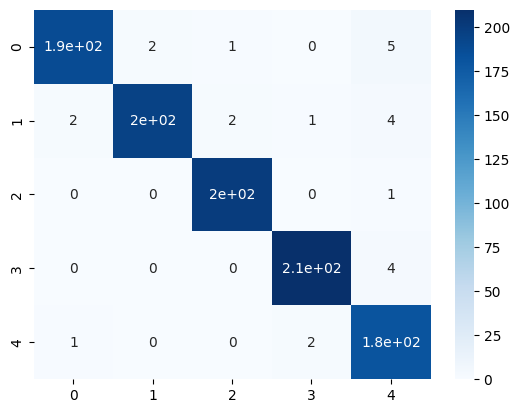

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(label, answer)
#print(cm)

sns.heatmap(cm, annot=True, cmap='Blues')